# Reinforcement Learning - Monte Carlo
If you want to test/submit your solution **restart the kernel, run all cells and submit the mc_autograde.py file into codegrade.**

In [1]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
# All cells that start with %%execwritefile should be in mc_autograde.py file after running all cells.
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [2]:
%%execwritefile mc_autograde.py
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting mc_autograde.py


In [3]:
import matplotlib.pyplot as plt
import sys


%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Monte Carlo Prediction

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [4]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we no longer have transition probabilities and we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [5]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [6]:
# We can also look at the documentation/implementation of a method
?env.step

In [7]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary , a function or a class with a function, where we use the last option. Moreover, it is often useful (as you will see later) to implement a function that returns  the probability $\pi(a|s)$ for the state action pair (the probability that this policy would perform certain action in given state). We group these two functions in a policy class. To get started, let's implement this simple policy for BlackJack.

In [8]:
%%execwritefile -a mc_autograde.py

class SimpleBlackjackPolicy(object):
    """
    A simple BlackJack policy that sticks with 20 or 21 points and hits otherwise.
    """
    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains a probability
        of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """
        probs = np.zeros(len(states))
        for i, (player_sum, _, _) in enumerate(states):
            if player_sum < 20 and actions[i] == 1:
                probs[i] = 1
            elif player_sum >= 20 and actions[i] == 0:
                probs[i] = 1
        return np.array(probs)
    
    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            state: current state

        Returns:
            An action (int).
        """
        options = [0,1]
        action = np.random.choice(options, p=self.get_probs([state]*2, options))
        
        return action

Appending to mc_autograde.py


In [9]:
# Let's check if it makes sense
env = BlackjackEnv()
s = env.reset()
policy = SimpleBlackjackPolicy()
print("State: {}\nSampled Action: {}\nProbabilities [stick, hit]: {}".format(s, policy.sample_action(s), policy.get_probs([s,s],[0,1])))

State: (14, 10, False)
Sampled Action: 1
Probabilities [stick, hit]: [0. 1.]


Since there are multiple algorithms which require data from single episode (or multiple episodes) it is often useful to write a routine that will sample a single episode. This will save us some time later. Implement a *sample_episode* function which uses environment and policy to sample a single episode.

In [10]:
%%execwritefile -a mc_autograde.py

def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        Hint: Do not include the state after the termination in the list of states.
    """
    states, actions, rewards, dones = [], [], [], []
    
    s = env.reset()
    done = False
    # if player is bust, done==True
    while not done: 
        states.append(s)
        
        a = policy.sample_action(s)
        s, r, done, _ = env.step(a)
        
        actions.append(a)
        rewards.append(r)
        dones.append(done)
    
    return states, actions, rewards, dones

Appending to mc_autograde.py


In [11]:
# Let's sample some episodes
env = BlackjackEnv()
policy = SimpleBlackjackPolicy()
for episode in range(3):
    trajectory_data = sample_episode(env, policy)
    print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))

Episode 0:
States [(13, 7, False), (15, 7, False), (19, 7, False)]
Actions [1, 1, 1]
Rewards [0, 0, -1]
Dones [False, False, True]

Episode 1:
States [(13, 1, False)]
Actions [1]
Rewards [-1]
Dones [True]

Episode 2:
States [(13, 10, False)]
Actions [1]
Rewards [-1]
Dones [True]



Now implement the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar. Use the sampling function from above to sample data from a single episode.

In [12]:
%%execwritefile -a mc_autograde.py

def mc_prediction(env, policy, num_episodes, discount_factor=1.0, sampling_function=sample_episode):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of current V and count of returns for each state
    # to calculate an update.
    V = defaultdict(float)
    returns_count = defaultdict(float)
    returns_sum = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
        trajectory_data = sampling_function(env, policy)
        states, actions, rewards, dones = trajectory_data
        T_trajectory = len(states)
        G = 0
        for t in range(T_trajectory-1, -1, -1):
            state_t = states[t]
            # use state[t] because this is the state that came
            # before doing action actions[t] and receiving reward rewards[t]
            G = discount_factor * G + rewards[t]
            if state_t not in states[:t]:
                returns_sum[state_t] += G
                returns_count[state_t] += 1
                V[state_t] = returns_sum[state_t] / returns_count[state_t]
    return V

Appending to mc_autograde.py


In [13]:
V_10k = mc_prediction(env, SimpleBlackjackPolicy(), num_episodes=10000)
print(V_10k)

100%|██████████| 10000/10000 [00:01<00:00, 5099.35it/s]

defaultdict(<class 'float'>, {(20, 5, False): 0.668918918918919, (17, 5, False): -0.6637931034482759, (19, 4, False): -0.7567567567567568, (19, 4, True): -0.42857142857142855, (14, 4, True): -0.25, (13, 4, True): -0.6, (20, 10, False): 0.40842787682333875, (19, 10, False): -0.7075892857142857, (17, 10, False): -0.7099236641221374, (21, 7, False): 0.9594594594594594, (18, 7, False): -0.5981308411214953, (14, 10, False): -0.6246851385390428, (12, 10, False): -0.6134453781512605, (21, 5, False): 0.9298245614035088, (15, 5, False): -0.6764705882352942, (15, 8, False): -0.44680851063829785, (20, 2, False): 0.62, (16, 7, False): -0.7619047619047619, (20, 3, False): 0.6538461538461539, (16, 2, False): -0.7735849056603774, (14, 2, False): -0.7047619047619048, (16, 8, False): -0.689922480620155, (15, 4, False): -0.7289719626168224, (16, 4, True): -1.0, (16, 1, False): -0.7352941176470589, (15, 6, False): -0.6055045871559633, (20, 9, False): 0.8220858895705522, (18, 9, False): -0.628865979381443

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [14]:
%%time
# Let's run your code one time
V_10k = mc_prediction(env, SimpleBlackjackPolicy(), num_episodes=10000)
V_500k = mc_prediction(env, SimpleBlackjackPolicy(), num_episodes=500000)

100%|██████████| 500000/500000 [01:34<00:00, 5297.19it/s]

CPU times: user 1min 35s, sys: 3.62 s, total: 1min 39s
Wall time: 1min 36s


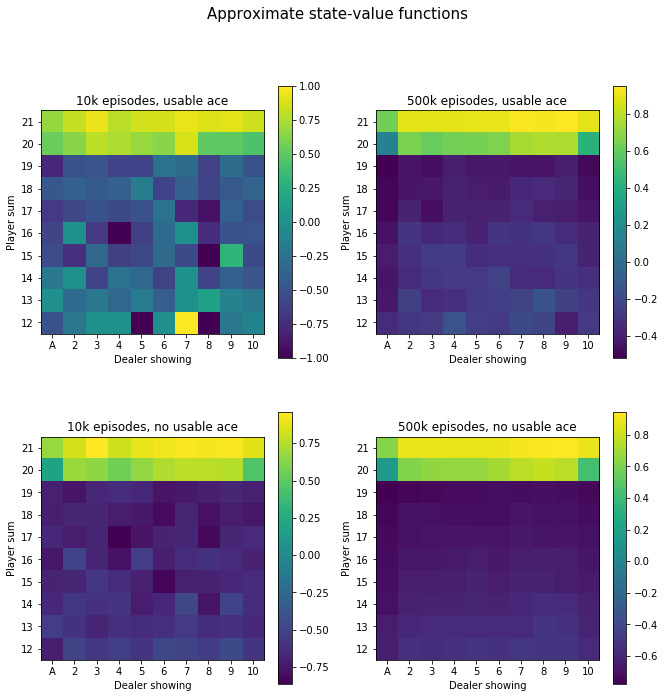

In [15]:

def get_heatmap(V_, usables):
    def min_max(lst):
        return min(lst), max(lst)
    min_sum, max_sum = min_max([player_sum for player_sum,_,_ in V_])
    min_dealer, max_dealer = min_max([dealer_card for _,dealer_card,_ in V_])
    
    heatmap = np.zeros((max_sum-min_sum+1, max_dealer-min_dealer+1))
    
    for s in V_:
        player_sum, dealer_card, usable = s
        if (usables and usable) or (not usables and not usable):
            heatmap[player_sum-min_sum, dealer_card-min_dealer] = V_[s]
            
    return np.flip(heatmap, axis=0), (min_sum, max_sum, min_dealer, max_dealer)

def show_heatmap(heatmap, extremes, title=""):
    min_sum, max_sum, min_dealer, max_dealer = extremes
    plt.imshow(heatmap)
    plt.colorbar()
    plt.yticks(range(heatmap.shape[0]), range(max_sum, min_sum-1, -1))
    plt.xticks(range(heatmap.shape[1]), ["A"] + list(range(min_dealer+1, max_dealer+1)))
    plt.xlabel("Dealer showing")
    plt.ylabel("Player sum")
    plt.title(title)
#     plt.show()
    
V10_u, V10_u_extr = get_heatmap(V_10k, usables=True)
V10_no_u, V10_no_u_extr = get_heatmap(V_10k, usables=False)
V500_u, V500_u_extr = get_heatmap(V_500k, usables=True)
V500_no_u, V500_no_u_extr = get_heatmap(V_500k, usables=False)

plt.figure(figsize=(11,11))
plt.suptitle("Approximate state-value functions", fontsize=15)
plt.subplot(2,2,1)
show_heatmap(V10_u, V10_u_extr, "10k episodes, usable ace")
plt.subplot(2,2,3)
show_heatmap(V10_no_u, V10_no_u_extr, "10k episodes, no usable ace")
plt.subplot(2,2,2)
show_heatmap(V500_u, V500_u_extr, "500k episodes, usable ace")
plt.subplot(2,2,4)
show_heatmap(V500_no_u, V500_no_u_extr, "500k episodes, no usable ace")

## 2. Off-policy Monte Carlo prediction
In real world, it is often beneficial to learn from the experience of others in addition to your own. For example, you can probably infer that running off the cliff with a car is a bad idea if you consider what "return" people who have tried it received.

Similarly, we can benefit from the experience of other agents in reinforcement learning. In this exercise we will use off-policy monte carlo to estimate the value function of our target policy using the experience from a different behavior policy. Our target policy will be the simple policy defined above (stick if we have *20* or *21* points) and we will use a random policy that randomly chooses to stick or hit (both with 50% probability) as a behavior policy. As a first step, implement a random BlackJack policy.

In [16]:
%%execwritefile -a mc_autograde.py

class RandomBlackjackPolicy(object):
    """
    A random BlackJack policy.
    """
    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains 
        a probability of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """
        # YOUR CODE HERE
        probs=np.zeros(len(states))+0.5
        return np.array(probs)
    
    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            state: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        options = [0,1]
        action = np.random.choice(options, p=self.get_probs([state]*2, options))
        return action


Appending to mc_autograde.py


In [17]:
# Let's check if it makes sense
env = BlackjackEnv()
s = env.reset()
policy = RandomBlackjackPolicy()
print("State: {}\nSampled Action: {}\nProbabilities [stick, hit]: {}".format(s, policy.sample_action(s), policy.get_probs([s,s],[0,1])))

State: (20, 6, False)
Sampled Action: 1
Probabilities [stick, hit]: [0.5 0.5]


Now implement the MC prediction algorithm with ordinary importance sampling. Use the sampling function from above to sample data from a single episode.

Hint: Get probs functions may be handy. You can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [18]:
%%execwritefile -a mc_autograde.py

def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0,
                           sampling_function=sample_episode):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    # YOUR CODE HERE
    # Keeps track of current V and count of returns for each state
    # to calculate an update.
    V = defaultdict(float)
    returns_count = defaultdict(float)
    returns_sum = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
        trajectory_data = sampling_function(env, behavior_policy)
        states, actions, rewards, dones = trajectory_data
        T_trajectory = len(states)-1
        G = 0
        for t in range(T_trajectory, -1, -1):
            state_t = states[t]
            action_t = actions[t]
            # use state[t] because this is the state that came
            # before doing action actions[t] and receiving reward rewards[t]
            G = discount_factor * G + rewards[t]
            imp_w = target_policy.get_probs([state_t],[action_t])/behavior_policy.get_probs([state_t],[action_t])
            if state_t not in states[:t]:
                returns_sum[state_t] += G * imp_w
                returns_count[state_t] += 1
                V[state_t] = returns_sum[state_t] / returns_count[state_t]
    # codegrade marks this part as incorrect, but we believe it's correct as we adapted the first part
    # of this assignment according to the slides concening importance sampling. Also, codegrade's error
    # message states that only after 10k episodes the v-value deviates from what it's supposed to be, so
    # this might be due to rounding issues or other small effects.

    return V

Appending to mc_autograde.py


In [19]:
V_10k = mc_importance_sampling(env, RandomBlackjackPolicy(), SimpleBlackjackPolicy(), num_episodes=10000)
print(V_10k)

100%|██████████| 10000/10000 [00:02<00:00, 4697.75it/s]

defaultdict(<class 'float'>, {(19, 10, False): array([-0.93710692]), (15, 7, False): array([-0.62365591]), (12, 6, False): array([-0.46808511]), (13, 3, False): array([-0.79120879]), (18, 7, False): array([-0.93506494]), (20, 5, False): array([0.56666667]), (12, 10, False): array([-0.65625]), (15, 1, False): array([-0.84210526]), (17, 10, False): array([-0.93770492]), (21, 7, False): array([1.25]), (16, 10, False): array([-0.76923077]), (12, 2, False): array([-0.32323232]), (20, 7, False): array([0.75]), (20, 10, False): array([0.38113949]), (14, 10, False): array([-0.77514793]), (12, 7, False): array([-0.52380952]), (14, 9, False): array([-0.575]), (12, 4, False): array([-0.75609756]), (15, 9, False): array([-0.86956522]), (17, 5, False): array([-0.75324675]), (19, 8, False): array([-0.83950617]), (16, 8, False): array([-0.43010753]), (21, 1, False): array([0.69387755]), (20, 2, False): array([0.51094891]), (21, 10, False): array([0.87309645]), (15, 10, False): array([-0.69421488]), (

In [20]:
%%time
# Let's run your code one time
V_10k2 = mc_importance_sampling(env, RandomBlackjackPolicy(), SimpleBlackjackPolicy(), num_episodes=10000)
V_500k2 = mc_importance_sampling(env, RandomBlackjackPolicy(), SimpleBlackjackPolicy(), num_episodes=500000)

100%|██████████| 500000/500000 [01:37<00:00, 5130.71it/s]

CPU times: user 1min 38s, sys: 4.38 s, total: 1min 43s
Wall time: 1min 39s


Plot the V function. Do the plots look like what you expected?

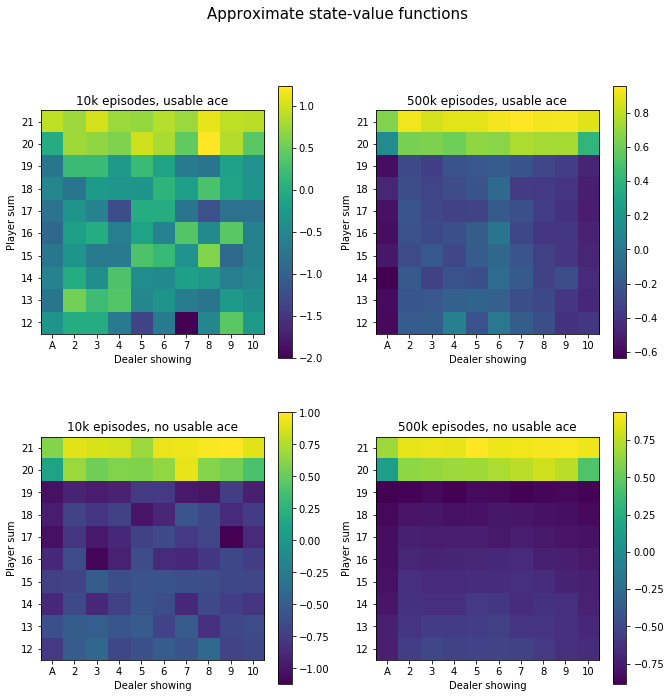

In [21]:
# YOUR CODE HERE
V10_u2, V10_u_extr2 = get_heatmap(V_10k2, usables=True)
V10_no_u2, V10_no_u_extr2 = get_heatmap(V_10k2, usables=False)
V500_u2, V500_u_extr2 = get_heatmap(V_500k2, usables=True)
V500_no_u2, V500_no_u_extr2 = get_heatmap(V_500k2, usables=False)

plt.figure(figsize=(11,11))
plt.suptitle("Approximate state-value functions", fontsize=15)
plt.subplot(2,2,1)
show_heatmap(V10_u2, V10_u_extr2, "10k episodes, usable ace")
plt.subplot(2,2,3)
show_heatmap(V10_no_u2, V10_no_u_extr2, "10k episodes, no usable ace")
plt.subplot(2,2,2)
show_heatmap(V500_u2, V500_u_extr2, "500k episodes, usable ace")
plt.subplot(2,2,4)
show_heatmap(V500_no_u2, V500_no_u_extr2, "500k episodes, no usable ace")

If you want to test/submit your solution **restart the kernel, run all cells and submit the mc_autograde.py file into codegrade.**